<h2><span style="color:blue">[Insert your ID HERE] [Insert your name HERE]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-29 12:57:18.151265


In [2]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above.
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

# print("\nIs GPU available?")
# print(torch.cuda.is_available())

# # print("\nCPU information")
# # !cat /proc/cpuinfo

# # print("\nMemory information")
# # !cat /proc/meminfo

# print("\nGPU information")
# !nvidia-smi

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

Python version
sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)

OS information
macOS-15.1-arm64-arm-64bit
PyTorch version:2.5.1
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-15.1-arm64-arm-64bit


## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>> - **Conv2d -> BatchNorm2d -> ReLU**
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OiTmrplD9gOrEJizLChyLp31R0QtoeHv" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1bBvAOdJeskMMyOrZtBCCnkEEgq9PgjX9" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)

STEP 1: LOADING DATASET
Files already downloaded and verified


In [5]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [6]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

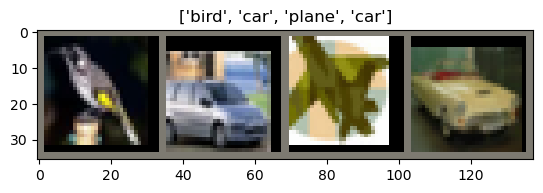

In [10]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=4,
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [11]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

cfg = [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP']

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.VGG16 = self._make_layers(cfg)
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 3)
        )

    def forward(self, x):
        out = self.VGG16(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3

        for x in cfg:
            if x == 'MP':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x

        return nn.Sequential(*layers)

STEP 3: CREATE MODEL CLASS (VGG16)


In [12]:
print('STEP 4: INSTANTIATE MODEL CLASS')

model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  33617987


VGG(
  (VGG16): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, k

In [13]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [14]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

import time

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    return correct / len(preds) * 100

def train_model(model, criterion, optimizer, num_epochs):
    start = time.time()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_train_acc = 0.0
        running_test_loss = 0.0
        running_test_acc = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_acc += accuracy(outputs, labels)
        train_loss.append(running_train_loss / len(train_loader))
        train_acc.append(running_train_acc / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                running_test_acc += accuracy(outputs, labels)
            test_loss.append(running_test_loss / len(test_loader))
            test_acc.append(running_test_acc / len(test_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.2f}%")
        
    end = time.time()
    print(f"Training time: {end-start}s")
    return train_loss, train_acc, test_loss, test_acc, model

train_loss, train_acc, test_loss, test_acc, model = train_model(model, criterion, optimizer, num_epochs)

STEP 7: TRAIN THE MODEL
Epoch 1/20, Train Loss: 1.1328, Train Acc: 43.61%, Test Loss: 0.9110, Test Acc: 56.57%
Epoch 2/20, Train Loss: 0.6863, Train Acc: 70.48%, Test Loss: 0.6955, Test Acc: 74.93%
Epoch 3/20, Train Loss: 0.5119, Train Acc: 80.96%, Test Loss: 0.4812, Test Acc: 82.77%
Epoch 4/20, Train Loss: 0.3717, Train Acc: 85.95%, Test Loss: 0.3789, Test Acc: 86.97%
Epoch 5/20, Train Loss: 0.3063, Train Acc: 88.62%, Test Loss: 0.3880, Test Acc: 86.37%
Epoch 6/20, Train Loss: 0.2629, Train Acc: 90.10%, Test Loss: 0.2643, Test Acc: 90.23%
Epoch 7/20, Train Loss: 0.2669, Train Acc: 89.82%, Test Loss: 0.2553, Test Acc: 90.47%
Epoch 8/20, Train Loss: 0.1987, Train Acc: 92.47%, Test Loss: 0.2203, Test Acc: 91.70%
Epoch 9/20, Train Loss: 0.1690, Train Acc: 93.82%, Test Loss: 0.3280, Test Acc: 90.37%
Epoch 10/20, Train Loss: 0.1483, Train Acc: 94.67%, Test Loss: 0.2635, Test Acc: 90.67%
Epoch 11/20, Train Loss: 0.1433, Train Acc: 94.85%, Test Loss: 0.3396, Test Acc: 89.57%
Epoch 12/20, Trai

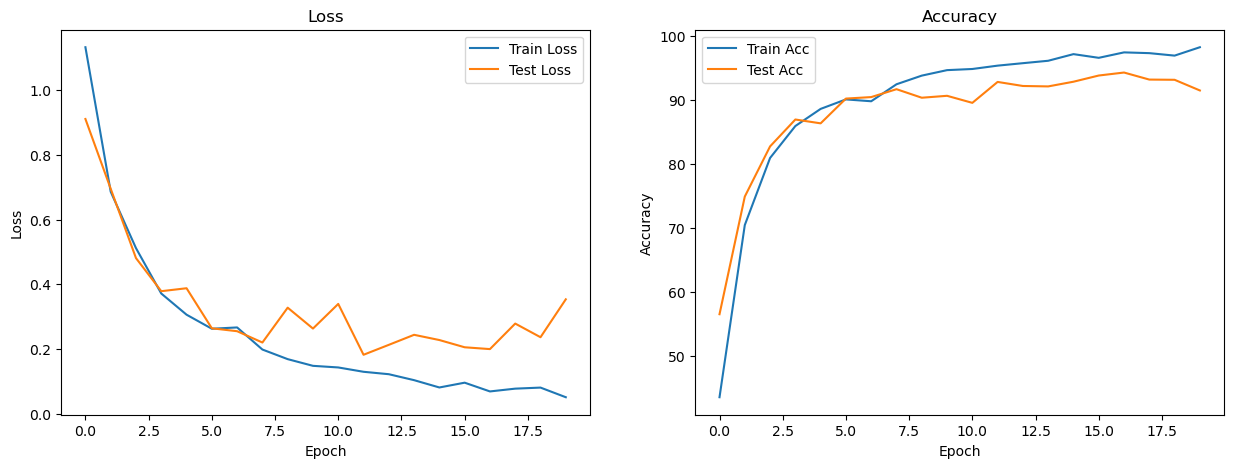

In [15]:
# graph
def display_graph(train_loss, train_acc, test_loss, test_acc):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(test_loss, label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='Train Acc')
    ax[1].plot(test_acc, label='Test Acc')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()
    
display_graph(train_loss, train_acc, test_loss, test_acc)

In [16]:
print('TEST THE MODEL and SAVE')

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 3000 test images: {} %'.format(100 * correct / total))
    
    # Save the model pt
    torch.save(model.state_dict(), 'LAB_1_VGG16.pt')

TEST THE MODEL and SAVE
Test Accuracy of the model on the 3000 test images: 91.5 %


Load PT Model and VISUALIZE THE RESULT


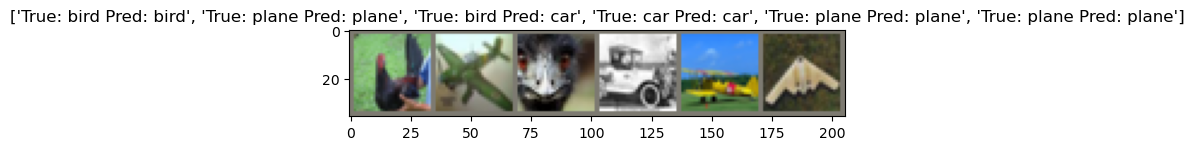

In [17]:
print('Load PT Model and VISUALIZE THE RESULT')

loaded_model = VGG()
loaded_model.to(device)
loaded_model.load_state_dict(torch.load('LAB_1_VGG16.pt', map_location=device, weights_only=False))

with torch.no_grad():
    model.eval()
    # Visualize the result of only 4 images
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    # Select only the first 4 images and labels
    images = images[5:11]
    labels = labels[5:11]
    
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Make a grid from the batch
    out = torchvision.utils.make_grid(images.cpu())
    
    # Show images with Ground Truth and Predictions
    imshow(out, title=[f'True: {class_names[x]} Pred: {class_names[y]}' for x, y in zip(labels, predicted)])